In [1]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from matplotlib import pyplot as plt
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.stats import binom, geom 
import numpy as np

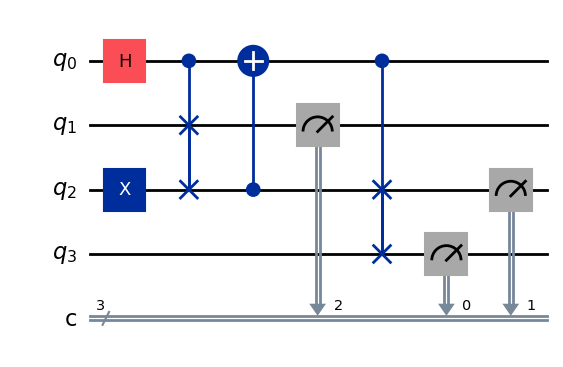

In [2]:
# one peg 
qc = QuantumCircuit(4,3)
qc.h(0)
qc.x(2)
qc.cswap(0,1,2)
qc.cx(2,0)
qc.cswap(0,2,3)
qc.measure([3,2,1], [0,1,2])
qc.draw('mpl')

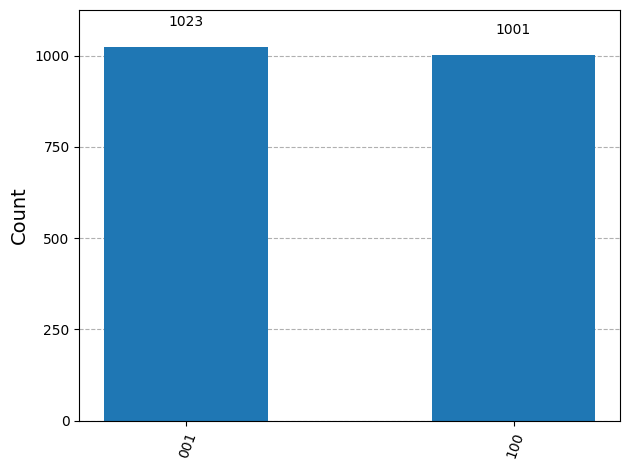

In [3]:
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
job = simulator.run(qc_t, shots=2024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

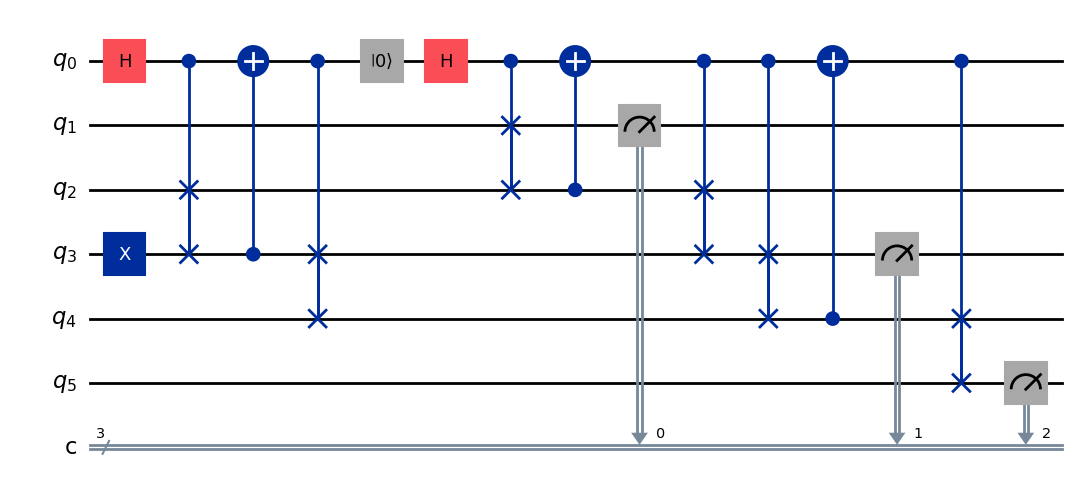

In [4]:
# three peg 

qc = QuantumCircuit(6,3)
qc.h(0)
qc.x(3)
qc.cswap(0,2,3)
qc.cx(3,0)
qc.cswap(0,3,4)
qc.reset(0)
qc.h(0)
n=1
while (n != 5):
    qc.cswap(0,n,n+1)
    if (n < 4):
        if (n != 2):
            qc.cx(n+1,0)
    n += 1
qc.measure([1,3,5], [0,1,2])
qc.draw('mpl')

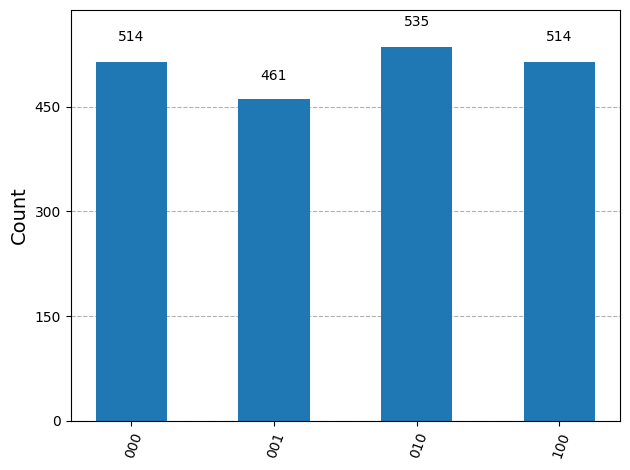

In [5]:
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
job = simulator.run(qc_t, shots=2024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [ ]:
def num_of_qbits(n):
    bits = 2*(n+1) # total qubits for n-level board = n+(n+1)+1
    return bits

def one_peg(qc, start):
    qc.cswap(0, start-1, start)
    qc.cx(start, 0)
    qc.cswap(0, start, start+1)
    return qc 

def measure_gb(qc):
    qb = qc.num_qubits
    cb = 0
    for i in range(1, qb, 2): 
        # measure 1,3,5 qubits as 1 is always a bucket 
        qc.measure(i, cb)
        cb += 1
    return qc

def multi_swap(qc, curr, curr_level):
    for i in range(curr_level):
        qc = one_peg(qc, curr)
        qc.cx(curr+1, 0)
        if (i == curr_level-1):
            qc.cx(curr, curr-1)
        curr += 2
    return qc 

def multi_swap_fine_tuned(qc, curr, curr_level, t):
    for i in range(curr_level):
        qc = one_peg(qc, curr)
        qc.reset(0)
        qc.rx(t, 0)
        if (i == curr_level-1):
            qc.cx(curr, curr-1)
        curr += 2
    return qc 


def gboard(n):
    qbits = num_of_qbits(n)
    start = qbits // 2
    qc = QuantumCircuit(qbits, qbits-1)
    qc.x(start)

    for i in range(n):
        for j in range(i):
            qc = one_peg(qc, start+i)

print(num_of_qbits(4))

10


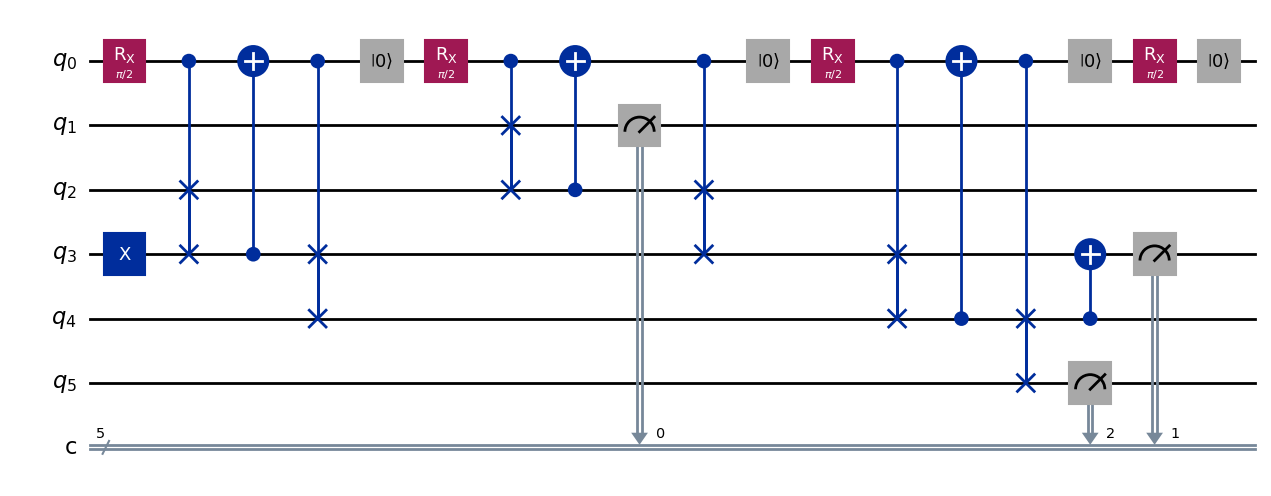

In [80]:
def galton_board_circuit(n, bias=False, theta=np.pi/2, q_walk=False):
    qbits = num_of_qbits(n)
    start = qbits // 2
    qc = QuantumCircuit(qbits, qbits-1)
    qc.x(start)
    curr = start
    curr_level = 1
    while curr_level < n+1:
        if bias == True :
            qc.rx(theta,0)
        else:
            qc.h(0)
        if curr_level < 2:
            qc = one_peg(qc, curr)
        else:
            if bias:
                t = theta
                qc = multi_swap_fine_tuned(qc, curr-1, curr_level=curr_level, t=t)
            else:
                qc = multi_swap(qc, curr-1, curr_level=curr_level)
            curr -= 1
        if q_walk == False:
            qc.reset(0)
        curr_level += 1
    return measure_gb(qc)
galton = galton_board_circuit(2, bias=True, theta=np.pi/2, q_walk=False)
galton.draw('mpl')

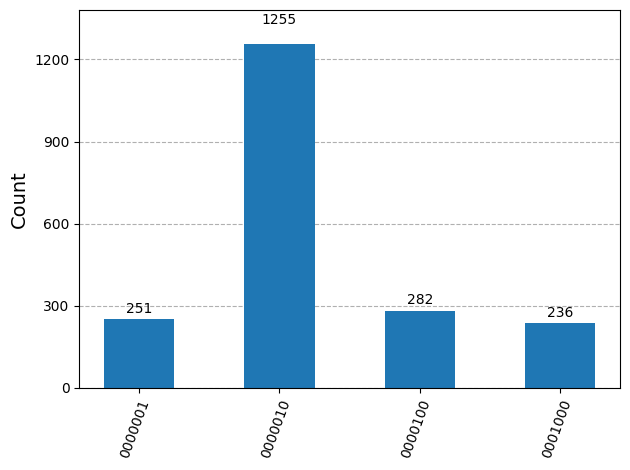

In [37]:
qc = galton
shots = 2024
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
job = simulator.run(qc_t, shots=shots)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [ ]:
def mse_exponential(counts, lambda_param, shots):
    sorted_counts = {int(k, 2): counts[k] for k in sorted(counts.keys())}
    
    empirical, expected, mse_total = [], [], 0

    outcomes = sorted(sorted_counts.keys())

    p = 1 - np.exp(-lambda_param)

    max_outcome = 0
    if len(outcomes) > 0:
        max_outcome = max(outcomes)

    for i in range(max_outcome + 1):
        empirical_val = sorted_counts.get(i, 0) / shots
        empirical.append(empirical_val)

        expected_val = geom.pmf(i + 1, p)
        expected.append(expected_val)
        
        mse_total += (empirical_val - expected_val)**2
        
    return {
        "mse": mse_total,
        "empirical": empirical,
        "empirical_mean": np.mean(empirical),
        "empirical_var": np.var(empirical),
        "expected": expected,
        "expected_mean": np.mean(expected),
        "expected_var": np.var(expected)
    }

LAMBDA = 0.5
SHOTS = 2024
n=4

exponential_board = galton_board_circuit(n, bias=True, theta=np.acos(1/np.sqrt(n*LAMBDA)))
exponential_board.draw('mpl')

qc = exponential_board
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
job = simulator.run(qc_t, shots=SHOTS)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)


results = mse_exponential(counts, lambda_param=LAMBDA, shots=SHOTS)

print(f"MSE: {results['mse']}\n")
print(f"Empirical Distribution: {results['empirical']}")
print(f"Expected Distribution: {results['expected']}\n")
print(f"Empirical Mean: {results['empirical_mean']:.4f}, Expected Mean: {results['expected_mean']:.4f}")
print(f"Empirical Variance: {results['empirical_var']:.4f}, Expected Variance: {results['expected_var']:.4f}")



MSE: 0.8407367193649622

Empirical Distribution: [0.0, 0.0, 0.0, 0.0, 0.020256916996047432, 0.0, 0.0, 0.0, 0.24357707509881424, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7361660079051383]
Expected Distribution: [np.float64(0.3934693402873666), np.float64(0.2386512185411911), np.float64(0.1447492810230125), np.float64(0.08779487691181713), np.float64(0.0532502846127139), np.float64(0.032297930256034856), np.float64(0.019589684945545444), np.float64(0.01188174453358432), np.float64(0.007206642350491874), np.float64(0.004371049539156839), np.float64(0.0026511755606214), np.float64(0.0016080192617977088), np.float64(0.000975312983688786), np.float64(0.0005915572274230562), np.float64(0.0003587975954066826), np.float64(0.00021762174224532177), np.float64(0.00013199425889186766)]

Empirical Mean: 0.0588, Expected Mean: 0.0588
Empirical Variance: 0.0319, Expected Variance: 0.0109


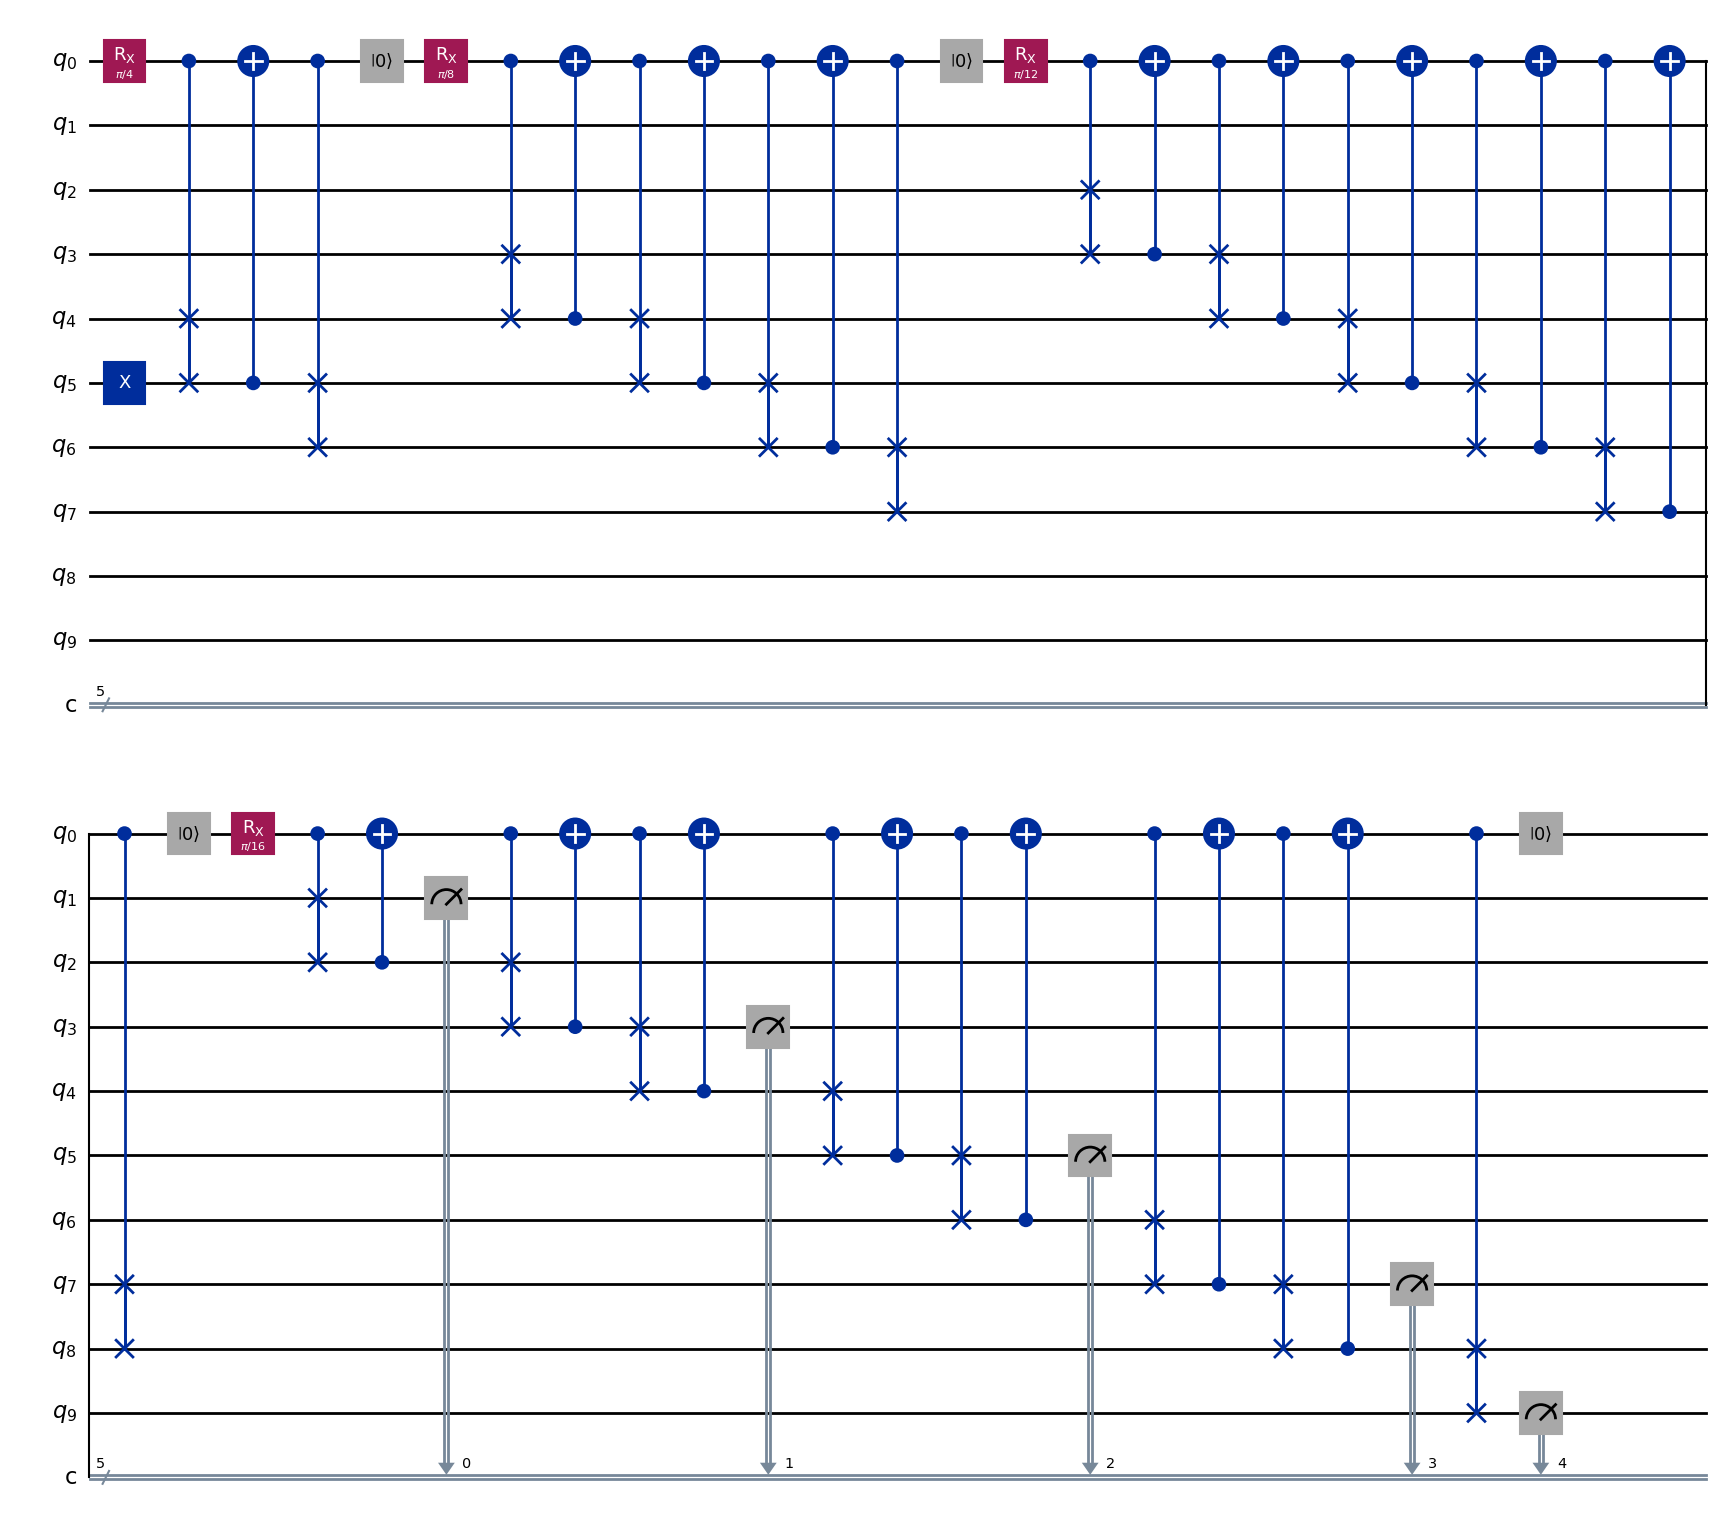

In [93]:
exponential_board.draw('mpl')

In [119]:
def mse(counts):
    empirical = []
    expected = []

    keys = list(counts.keys())

    mse = 0 

    for i in range(len(keys)):
        empirical_val = counts[keys[i]]/shots
        empirical.append(empirical_val)
        expected_val = binom.pmf(i, len(keys)-1, 0.5)
        expected.append(expected_val)
        mse += (empirical_val - expected_val)**2

    print(f"mse: {mse}")
    print(f"empirical: {empirical}")
    print(f"empirical_mean: {np.mean(empirical)}; var: {np.var(empirical)}")
    print(f"expected: {expected}")
    print(f"expected: {np.mean(expected)}; var: {np.var(expected)}")
    print(f"counts: {counts}")

sorted_counts = {k: counts[k] for k in sorted(counts.keys())}

mse(sorted_counts)


mse: 0.0998535118108392
empirical: [0.058300395256917, 0.3893280632411067, 0.11808300395256917, 0.3700592885375494, 0.06422924901185771]
empirical_mean: 0.2; var: 0.021997629239638168
expected: [np.float64(0.0625), np.float64(0.24999999999999994), np.float64(0.37500000000000017), np.float64(0.25), np.float64(0.0625)]
expected: 0.2; var: 0.01468750000000001
counts: {'00001': 118, '00010': 788, '00100': 239, '01000': 749, '10000': 130}


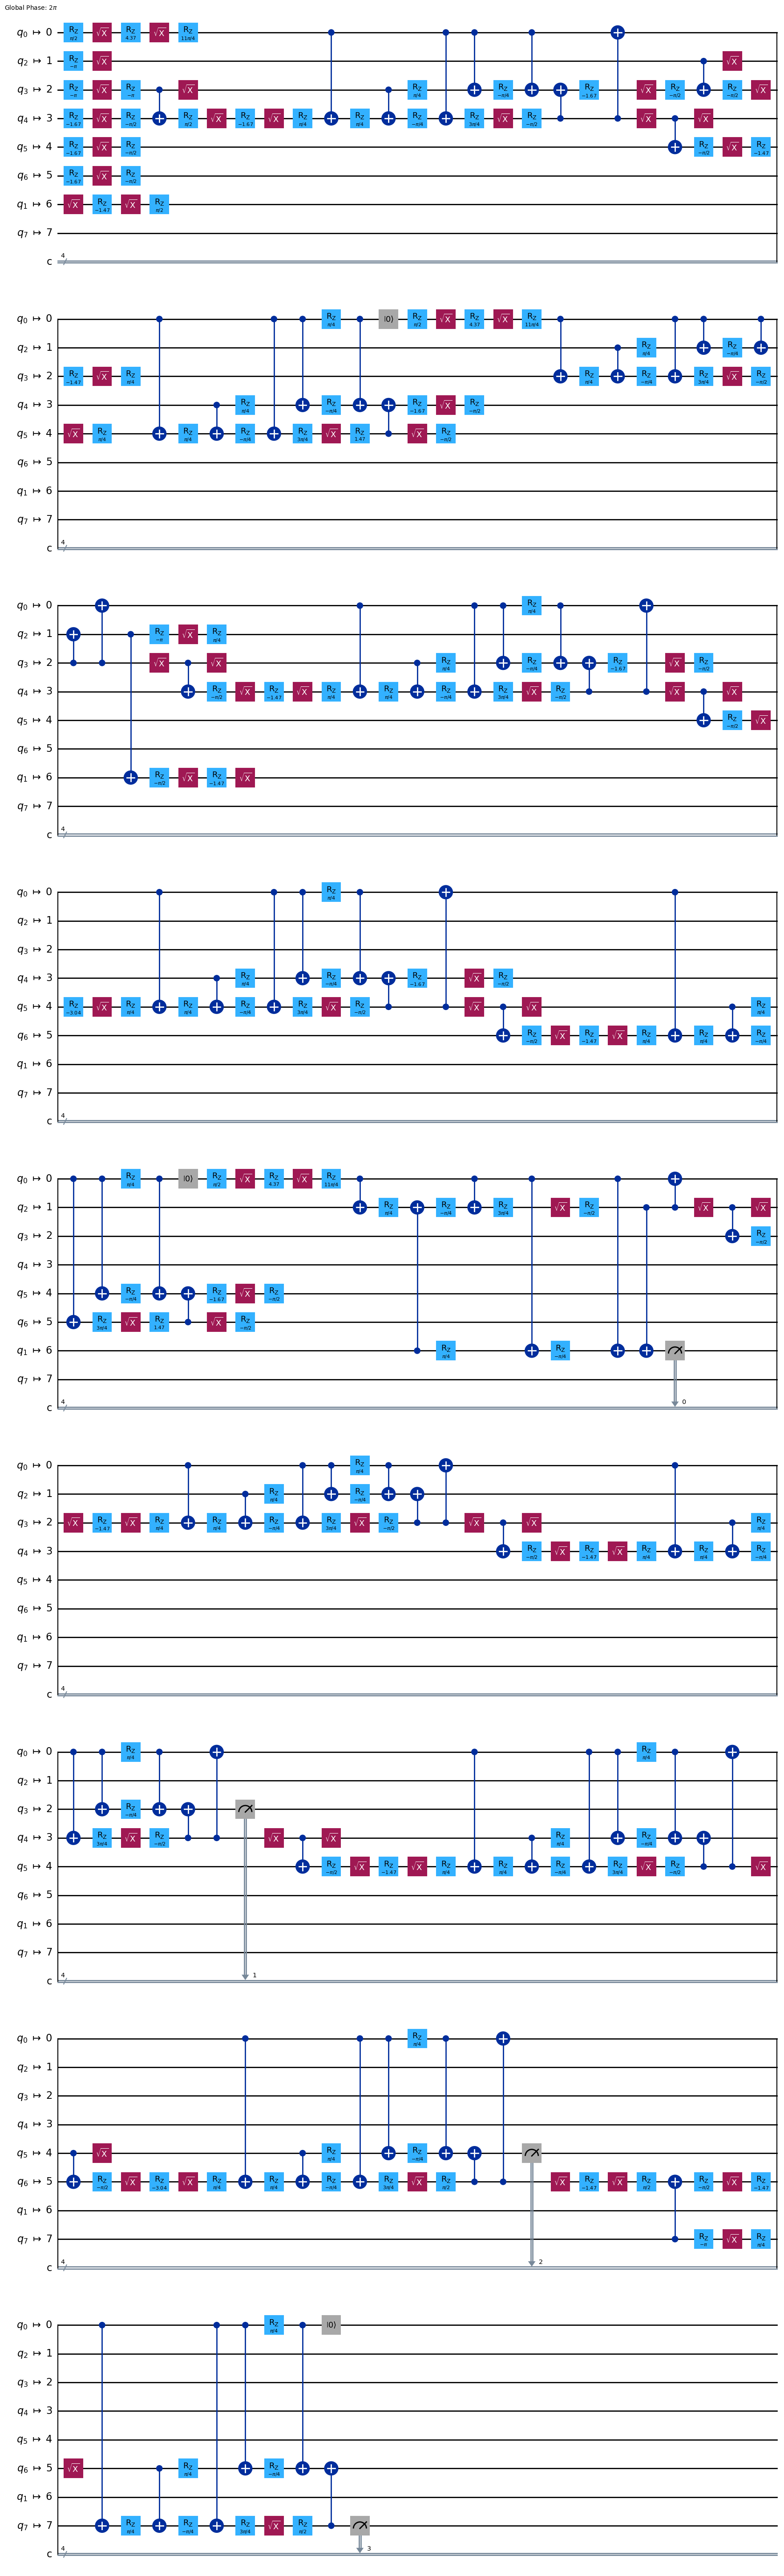

In [40]:
from qiskit import transpile
from qiskit.visualization import plot_circuit_layout
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.providers.fake_provider import GenericBackendV2

# Generate your biased circuit
n_layers = 3
lambda_val = 1
theta = 2 * np.arcsin(np.sqrt(lambda_val / n_layers))

qc = galton_board_circuit(n_layers, bias=True, theta=theta)

# Transpile the circuit for a simulator backend


backend = GenericBackendV2(qc.num_qubits)
qc_transpiled = transpile(qc, backend=backend, optimization_level=3)
qc_transpiled.draw('mpl')


# Display the transpiled circuit
qc_transpiled.draw('mpl')  # Or use 'text' for terminal-based view


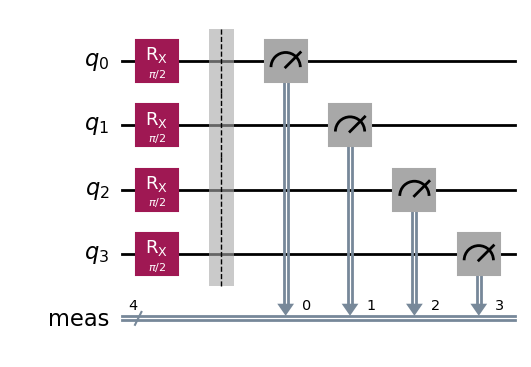

In [76]:
n=4
qc = QuantumCircuit(n)
for i in range(n):
    qc.rx(np.pi/2, i)
qc.measure_all()
qc.draw('mpl')

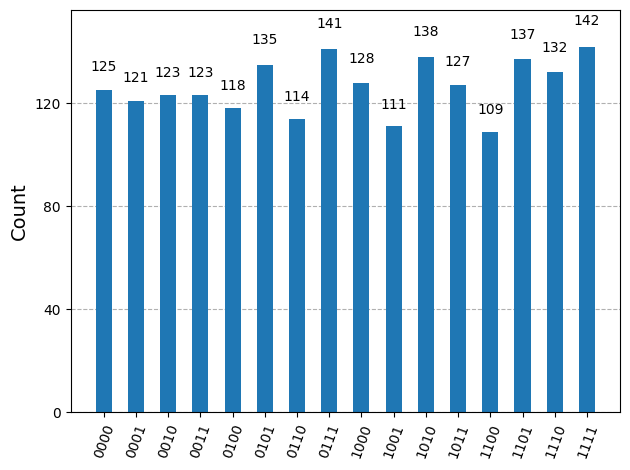

In [77]:
counts = {k: counts[k] for k in sorted(counts.keys())}
shots = 2024
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
job = simulator.run(qc_t, shots=shots)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [131]:
def create_gaussian_circuit_v2(n):
    """
    Creates a robust Galton board circuit with a clean, one-hot encoding.
    Uses n+2 qubits total.
    """
    num_position_qubits = n + 1
    coin_qubit = n + 1
    
    # Create the circuit
    # n+1 classical bits for the one-hot measurement result
    qc = QuantumCircuit(num_position_qubits + 1, num_position_qubits)
    
    # 1. Initialize the ball at the starting position (e.g., the middle-left bin)
    start_pos = n // 2
    qc.x(start_pos)
    
    # 2. Iterate through each layer of pegs
    for i in range(n):
        # Apply coin flip to the dedicated coin qubit
        qc.h(coin_qubit)
        
        # Ripple through the possible positions and apply a controlled-swap
        # A ball at position `j` can move to `j+1`
        for j in range(i + 1):
            # The position of the ball is j + start_pos - (i//2)
            current_ball_pos = start_pos - (i//2) + j
            
            # Swap with the next bin if the coin is |1>
            qc.cswap(coin_qubit, current_ball_pos, current_ball_pos + 1)
            
        # Reset the coin for a classical walk
        qc.reset(coin_qubit)
        
    # 3. Measure the position qubits
    qc.measure(range(num_position_qubits), range(num_position_qubits))
    
    return qc

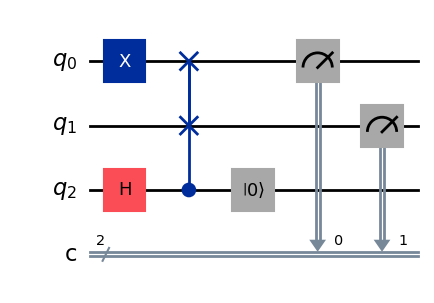

In [135]:
circ = create_gaussian_circuit_v2(1)
circ.draw('mpl')

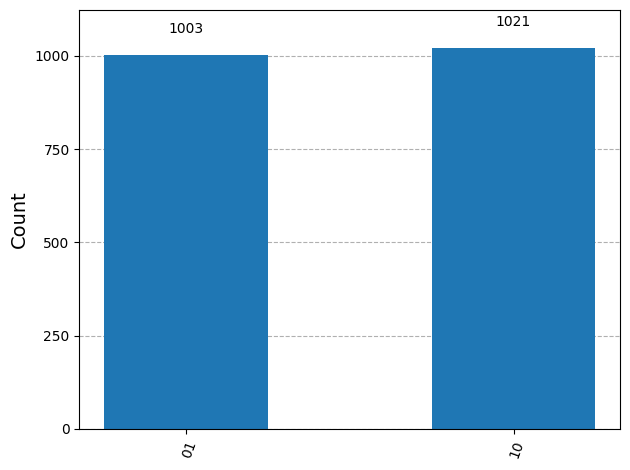

In [136]:
qc = circ
shots = 2024
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
job = simulator.run(qc_t, shots=shots)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

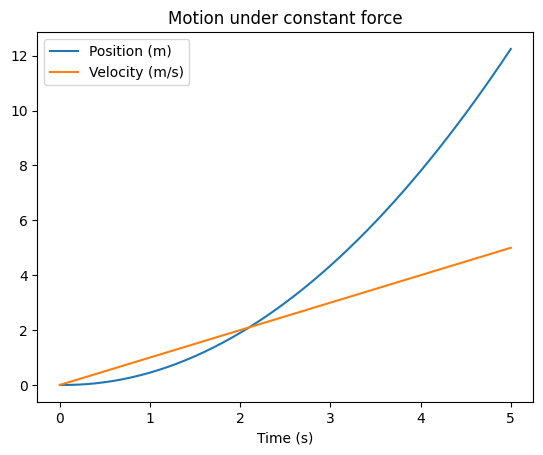

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 2.0           # mass in kg
F = 2.0           # force in N
dt = 0.1          # time step in s
T = 5.0           # total time in s

# Arrays
times = np.arange(0, T+dt, dt)
vel = np.zeros_like(times)
pos = np.zeros_like(times)

# Euler integration
for i in range(1, len(times)):
    a = F/m
    vel[i] = vel[i-1] + a*dt
    pos[i] = pos[i-1] + vel[i-1]*dt

# Plot results
plt.figure()
plt.plot(times, pos, label='Position (m)')
plt.plot(times, vel, label='Velocity (m/s)')
plt.xlabel('Time (s)')
plt.legend()
plt.title('Motion under constant force')
plt.show()

In [1]:
a = [0.28676, 0.23478, 0.19222, 0.15738, 0.12885]
print(sum(a))

0.9999899999999999


In [2]:
b = [0.00098, 0.01172, 0.14453, 0.37305, 0.46973]
print(sum(b))

1.00001


In [2]:

lam = 0.2
theta = 2 * np.arcsin(np.exp(-lam / 2))
print(f"Theta for λ = {lam}: {theta:.4f} radians ≈ {np.degrees(theta):.2f}°")


Theta for λ = 0.2: 2.2620 radians ≈ 129.60°


In [321]:
SHOTS = 1024
class GaltonBoard():
    def __init__(self, n):
        self.n = n
        self.theta_scheduler = None
        print(f"galton circuit of size {n} has been created.")

    # initialize the required circuit the n-level board
    def build_circuit(self):
        q_num = 2*(self.n+1) 
        qc = QuantumCircuit(q_num, self.n+1)
        return q_num, qc
    
    # one peg
    def one_peg(self, qc, start):
        qc.cswap(0, start-1, start)
        qc.cx(start, 0)
        qc.cswap(0, start, start+1)
        return qc
    
    def multi_swap(self, qc, start, curr, count):
        n = curr
        max_q = start + count
        while n != max_q:
            qc.cswap(0, n, n+1)
            if n < max_q - 1:
                qc.cx(n+1, 0)
            n += 1
        return qc
    def multi_swap_u(self, qc, curr, curr_level):
        for i in range(curr_level):
            qc = one_peg(qc, curr)
            qc.cx(curr+1, 0)
            if (i == curr_level-1):
                qc.cx(curr, curr-1)
            curr += 2
        return qc 

    def multi_swap_fine_tuned(self, qc, curr, curr_level, t):
        final_cnot = []
        for i in range(curr_level):
            qc = one_peg(qc, curr)
            if (i != curr_level-1):
                final_cnot.append([curr+1,curr+2])
                qc.reset(0)
                qc.rx(t[i], 0)
            curr += 2
        
        qc.barrier()
        
        for cnot in final_cnot:
            qc.cx(cnot[1], cnot[0])
            qc.reset(cnot[1])
        return qc 

    def theta_schedule_exp(self, lam):
        thetas = []
        alpha = 0.3269
        for level in range(1, self.n + 1):
            n = (self.n**2 + self.n) / 2
            theta_l = np.arcsin(np.sqrt(1/(lam*(n))))
            thetas.extend([theta_l] * level)
        return thetas
    
    def set_theta_scheduler(self, scheduler_fn):
        self.theta_scheduler = scheduler_fn


    def measure_gb(self,  qc):
        cb = 0
        for i in range(1, qc.num_qubits, 2):
            qc.measure(i, cb)
            cb += 1
        return qc
    
    # build the classical gb circuit that approximates to normal
    def classical_gb(self):
        qbits, qc = self.build_circuit()
        start = qbits // 2
        qc.x(start)
        curr = start
        count = 1
        while curr != 1:
            qc.h(0)
            if count < 2:
                qc = self.one_peg(qc, curr)
            else:
                qc = self.multi_swap(qc, start, curr-1, count)
            qc.reset(0)
            curr -= 1
            count += 1
        return self.measure_gb(qc)

    def exponential_gb(self, lam):
        qbits, qc = self.build_circuit()
        start = qbits // 2
        qc.x(start)
        curr = start
        curr_level = 1
        self.set_theta_scheduler(self.theta_schedule_exp)
        theta = self.theta_scheduler(lam)
        theta_idx = 0
        while curr_level < self.n+1:
            qc.rx(theta[theta_idx],0)
            theta_idx += 1
            if curr_level < 2:
                qc = self.one_peg(qc, curr)
            else:
                thetas_for_layer = theta[theta_idx: theta_idx + curr_level -1 ]
                qc = self.multi_swap_fine_tuned(qc, curr-1, curr_level, thetas_for_layer)
                curr -= 1
                theta_idx += curr_level -1 
            qc.reset(0)
            curr_level += 1
        print(theta)
        return self.measure_gb(qc)
    
    def quantum_walk_gb(self):
        qbits, qc = self.build_circuit()
        start = qbits // 2
        qc.x(start)
        curr = start
        count = 1
        while curr != 1:
            qc.h(0)
            if count < 2:
                qc = self.one_peg(qc, curr)
            else:
                qc = self.multi_swap(qc, start, curr-1, count)
            curr -= 1
            count += 1
        return self.measure_gb(qc)   

    def run_circuit(self, qc, sim, shots=SHOTS):
        job = sim.run(transpile(qc, sim), shots=shots)
        result = job.result()
        return result.get_counts()
    
    def mse(self, counts, shots=SHOTS):
        counts = {k: counts[k] for k in sorted(counts.keys())}
        empirical, expected, mse_total = [], [], 0
        keys = list(counts.keys())
        for i, key in enumerate(keys):
            e_val = counts[key] / shots
            b_val = binom.pmf(i, len(keys)-1, 0.5)
            empirical.append(e_val)
            expected.append(b_val)
            mse_total += (e_val - b_val)**2

        return {
            "mse": mse_total,
            "empirical": empirical,
            "empirical_mean": np.mean(empirical),
            "empirical_var": np.var(empirical),
            "expected": expected,
            "expected_mean": np.mean(expected),
            "expected_var": np.var(expected)
        }

    def compute_exponential_distribution(self, n_bins, lam):
        """Compute target exponential distribution over discrete bins"""
        x = np.arange(n_bins)
        unnorm = np.exp(-lam * x)
        return unnorm / np.sum(unnorm)
    
    def compute_tvd(self, p, q):
        """Total Variation Distance between two discrete distributions"""
        return 0.5 * np.sum(np.abs(p - q))
    
    def exponential_error(self, ):
        pass 

    def onehot_counts_to_distribution(self, counts_dict):
        n_bins = len(next(iter(counts_dict)))  # number of bits
        counts = np.zeros(n_bins)
        for bitstring, count in counts_dict.items():
            if bitstring.count('1') != 1:
                continue  # skip invalid outputs
            index = bitstring.index('1')  # index of '1' gives bucket
            counts[index] += count
        return counts / np.sum(counts)
    
    def view_circuit(self, qc):
        qc.draw('mpl')
        return plt.show()
    



galton circuit of size 4 has been created.
[np.float64(0.7853981633974484), np.float64(0.7853981633974484), np.float64(0.7853981633974484), np.float64(0.7853981633974484), np.float64(0.7853981633974484), np.float64(0.7853981633974484), np.float64(0.7853981633974484), np.float64(0.7853981633974484), np.float64(0.7853981633974484), np.float64(0.7853981633974484)]
observed: [0.54199219 0.36328125 0.08398438 0.01074219 0.        ]
expected: [0.28676373 0.23478228 0.19222347 0.15737927 0.12885125]
exponential distribution error: 0.38372742960662953


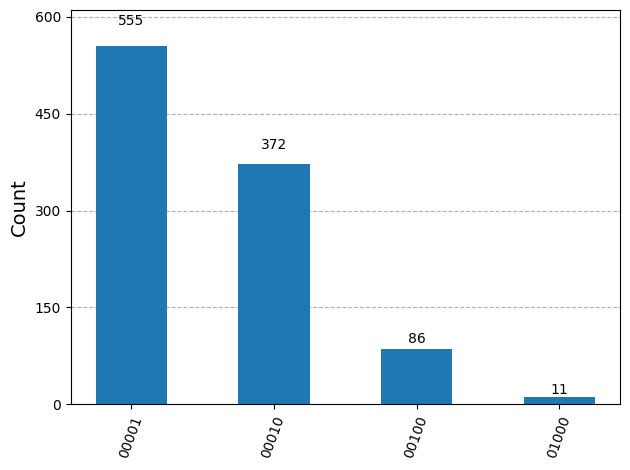

In [337]:
SHOTS = 1024
n = 4
LAM = 0.2
board = GaltonBoard(n)
board_circ = board.build_circuit()
expo = board.exponential_gb(lam=LAM)

sim = AerSimulator()
counts = board.run_circuit(expo, sim, shots=SHOTS)
counts_dist = board.onehot_counts_to_distribution(counts_dict=counts)
# counts_dist = np.flip(counts_dist)
print(f"observed: {counts_dist}")
standard_exp = board.compute_exponential_distribution(n+1, LAM)
print(f"expected: {standard_exp}")
exp_diff = board.compute_tvd(counts_dist, standard_exp)
print(f"exponential distribution error: {exp_diff}")



def flip_bitstrings(counts_dict):
    flipped = {}
    for k, v in counts_dict.items():
        flipped[k[::-1]] = v  # reverse bitstring
    return flipped

flipped_counts = flip_bitstrings(counts)
plot_histogram(flipped_counts)

# thetas = board.theta_schedule_exp(0.4)
# for i, θ in enumerate(thetas):
#     print(f"Peg {i+1}: θ = {np.degrees(θ):.2f}° → P(|1⟩) = {np.sin(θ/2)**2:.2f}")


ValueError: cannot convert float NaN to integer

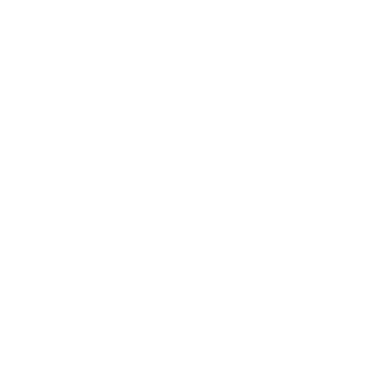

In [320]:
expo.draw('mpl')

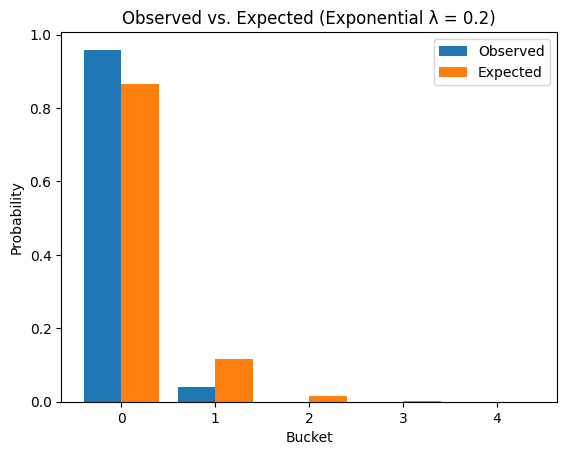

In [331]:
import matplotlib.pyplot as plt

x = range(len(counts_dist))
plt.bar([i - 0.2 for i in x], counts_dist, width=0.4, label='Observed')
plt.bar([i + 0.2 for i in x], standard_exp, width=0.4, label='Expected')
plt.xlabel('Bucket')
plt.ylabel('Probability')
plt.title('Observed vs. Expected (Exponential λ = 0.2)')
plt.legend()
plt.show()


In [133]:
a = [0,1,2,3]
b = [0,1,2]

for i, (j, k) in enumerate(zip(a,b)):
    print(f"({i}, {j}, {k})")

(0, 0, 0)
(1, 1, 1)
(2, 2, 2)


In [169]:
a[1:]

[1, 2, 3]

In [186]:
def theta_schedule_exp(n, lam):
    thetas = []
    # 1 Rx per level, then ℓ peg-specific thetas per level
    for level in range(1, n + 1):
        θ = 2 * np.arcsin(np.exp(-lam * level / 2))
        thetas.append(θ)            # Rx before pegs
        thetas.extend([θ] * level)  # one θ per peg in this level
    return thetas

thetas = theta_schedule_exp(5, 0.4)
print(thetas)

[np.float64(1.9183939491005608), np.float64(1.9183939491005608), np.float64(1.4692799809108559), np.float64(1.4692799809108559), np.float64(1.4692799809108559), np.float64(1.1618839874413038), np.float64(1.1618839874413038), np.float64(1.1618839874413038), np.float64(1.1618839874413038), np.float64(0.9320281305010423), np.float64(0.9320281305010423), np.float64(0.9320281305010423), np.float64(0.9320281305010423), np.float64(0.9320281305010423), np.float64(0.75345501611715), np.float64(0.75345501611715), np.float64(0.75345501611715), np.float64(0.75345501611715), np.float64(0.75345501611715), np.float64(0.75345501611715)]


In [ ]:
from scipy.optimize import minimize_scalar
import numpy as np
from qiskit_aer import AerSimulator

# === 1. Parametric Theta Schedule (outside class) ===
def theta_schedule_parametric(n, lam, alpha=1.0):
    thetas = []
    for level in range(1, n + 1):
        scaled_depth = (level / n) ** alpha
        bias = np.exp(-lam * scaled_depth)
        theta_l = 2 * np.arcsin(bias)
        thetas.extend([theta_l] * level)
    return thetas


# === 2. Expected Exponential Distribution (truncated) ===
def compute_exponential_distribution(n_bins, lam):
    raw = np.array([np.exp(-lam * k) for k in range(n_bins)])
    return raw / np.sum(raw)

def compute_mean_variance(prob_dist):
    x = np.arange(len(prob_dist))
    mean = np.sum(x * prob_dist)
    var = np.sum((x - mean)**2 * prob_dist)
    return mean, var


# === 3. Loss Function Using Only the Board Object ===
def loss_function(alpha, lam, board, target_mean, target_var, shots=1024):
    thetas = theta_schedule_parametric(board.n, lam, alpha)
    board.set_theta_scheduler(lambda lam: thetas)

    qc = board.exponential_gb(lam)
    counts = board.run_circuit(qc, AerSimulator(), shots=shots)
    dist = board.onehot_counts_to_distribution(counts)
    dist = np.flip(dist)

    empirical_mean, empirical_var = compute_mean_variance(dist)

    loss = (empirical_mean - target_mean)**2 + (empirical_var - target_var)**2
    print(f"[α={alpha:.3f}] mean={empirical_mean:.4f}, var={empirical_var:.4f}, loss={loss:.6f}")
    return loss


# === 4. Main Optimization Function ===
def optimize_theta_scheduler(board, lam, shots=1024):
    n_bins = board.n + 1
    target_dist = compute_exponential_distribution(n_bins, lam)
    target_mean, target_var = compute_mean_variance(target_dist)

    result = minimize_scalar(
        loss_function,
        bounds=(0.2, 5),
        method='bounded',
        args=(lam, board, target_mean, target_var, shots)
    )

    best_alpha = result.x
    best_loss = result.fun
    print(f"\n✅ Optimal α: {best_alpha:.4f}, loss: {best_loss:.6f}")

    final_thetas = theta_schedule_parametric(board.n, lam, best_alpha)
    board.set_theta_scheduler(lambda lam: final_thetas)

    return best_alpha, best_loss, final_thetas




In [311]:
n = 3
lam = 0.5
board = GaltonBoard(n)

alpha, loss, thetas = optimize_theta_scheduler(board, lam, shots=1024)

qc = board.exponential_gb(lam)
counts = board.run_circuit(qc, AerSimulator(), shots=1024)
dist = board.onehot_counts_to_distribution(counts)
dist = np.flip(dist)

print(f"Final optimized distribution: {dist}")

galton circuit of size 3 has been created.
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[α=2.033] mean=nan, var=nan, loss=nan
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[α=3.167] mean=nan, var=nan, loss=nan
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


/var/folders/br/pfr4bqzn5tvg68w_j8qj2vgm0000gn/T/ipykernel_25128/2915711263.py:61: RuntimeWarning: invalid value encountered in arcsin
  theta_l = 2 * np.arcsin(np.exp((1/lam) * (depth) ** alpha))
/var/folders/br/pfr4bqzn5tvg68w_j8qj2vgm0000gn/T/ipykernel_25128/2915711263.py:181: RuntimeWarning: invalid value encountered in divide
  return counts / np.sum(counts)


[α=1.333] mean=nan, var=nan, loss=nan
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[α=2.466] mean=nan, var=nan, loss=nan
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[α=1.766] mean=nan, var=nan, loss=nan
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[α=2.199] mean=nan, var=nan, loss=nan
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[α=1.931] mean=nan, var=nan, loss=nan
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[α=2.097] mean=nan, var=nan, loss=nan
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[α=1.994] mean=nan, var=nan, loss=nan
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]
[α=2.058] mea

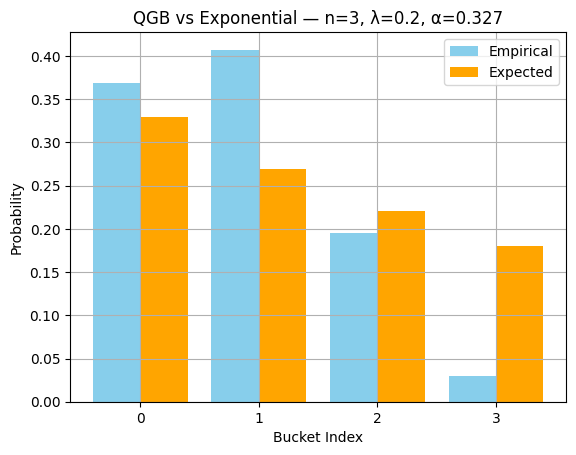

In [301]:
import matplotlib.pyplot as plt

bins = np.arange(board.n + 1)
expected = compute_exponential_distribution(board.n + 1, lam)
empirical = dist  # from your last run

plt.bar(bins - 0.2, empirical, width=0.4, label="Empirical", color="skyblue")
plt.bar(bins + 0.2, expected, width=0.4, label="Expected", color="orange")
plt.xticks(bins)
plt.xlabel("Bucket Index")
plt.ylabel("Probability")
plt.title(f"QGB vs Exponential — n={board.n}, λ={lam}, α={alpha:.3f}")
plt.legend()
plt.grid(True)
plt.show()


galton circuit of size 3 has been created.
[np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313)]
[np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313)]
[np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313)]
[np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313)]
[np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.1502619915109313), np.float64(1.15026199151

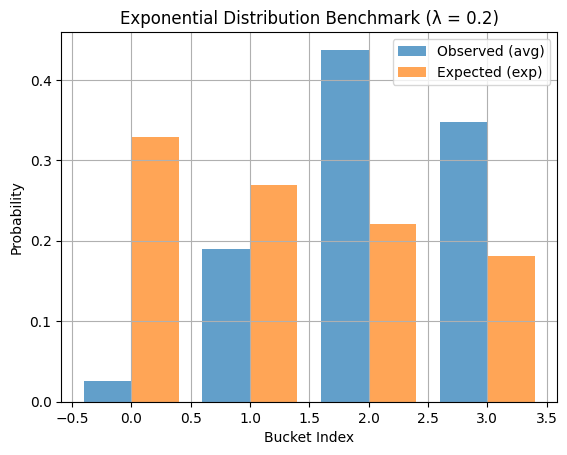

In [335]:
import sys
from pathlib import Path

# Add the root directory to sys.path
project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path().resolve().parent
sys.path.append(str(project_root))
from src.benchmark import benchmark_exponential_distribution

SHOTS = 1024
N = 3
LAM = 0.2
RUNS = 30

board = GaltonBoard(N)
results = benchmark_exponential_distribution(board, lam=LAM, shots=SHOTS, runs=RUNS)